In [1]:
import itertools

import numpy as np
import pandas as pd
import networkx as nx

from lingam import VARLiNGAM
from lingam.utils import print_causal_directions, print_dagc, make_dot

import matplotlib.pyplot as plt
import graphviz as gv
from IPython.display import display, Markdown

#  pip uninstall lingd; pip install ../../lingd
from lingd import CyclicVARLiNGAM

pd.options.display.max_columns = 1000

## 検証用関数

In [2]:
# 係数の範囲
COEF_RANGE = 0, 0.3

def _make_dag(n_features=8):
    sign = np.random.choice([-1, 1], size=(n_features, n_features))
    coef = np.random.uniform(*COEF_RANGE, size=(n_features, n_features))
    sparse = np.random.choice([0, 1], p=[0.3, 0.7], size=(n_features, n_features))

    graph = np.tril(sign * coef * sparse, k=-1)
    graph[np.isclose(graph, 0)] = 0
     
    G = nx.from_numpy_array(graph.T, create_using=nx.DiGraph)
    causal_order = np.array(list(nx.topological_sort(G)))
    
    return graph, causal_order

def _make_tau_coefs(tau_len, n_features=8):
    coefs = []
    for i in range(tau_len):
        sign = np.random.choice([-1, 1], size=(n_features, n_features))
        coef = np.random.uniform(*COEF_RANGE, size=(n_features, n_features))
        sparse = np.random.choice([0, 1], p=[0.5, 0.5], size=(n_features, n_features))

        coef = sign * coef * sparse
        coef[np.isclose(coef, 0)] = 0
        
        coefs.append(coef)
    return coefs

def _generate_var_graph(n_features=4, n_lags=1, is_shuffle=True):
    B = np.empty((n_lags + 1, n_features, n_features))
    
    B[0], causal_order = _make_dag(n_features=n_features)
    B[1:] = _make_tau_coefs(n_lags, n_features=n_features)
    
    if is_shuffle:
        indices = np.random.permutation(n_features)
        for i in range(len(B)):
            B[i] = B[i][indices][:, indices]
        causal_order = causal_order[indices]
        
    return B, causal_order

def _get_example_graph():
    B = np.array([
        [
            [0,-0.12,0,0,0],
            [0,0,0,0,0],
            [-0.41,0.01,0,-0.02,0],
            [0.04,-0.22,0,0,0],
            [0.15,0,-0.03,0,0],
        ],
        [
            [-0.32,0,0.12,0.32,0],
            [0,-0.35,-0.1,-0.46,0.4],
            [0,0,0.37,0,0.46],
            [-0.38,-0.1,-0.24,0,-0.13],
            [0,0,0,0,0],
        ]
    ])

    causal_order = np.array([1, 0, 3, 2, 4])
    
    return B, causal_order

def _make_var_data(B, T=100):
    k = len(B) - 1
    n_features = len(B[0])
    
    I_minus_B0_inv = np.linalg.pinv(np.eye(n_features) - B[0])

    X = np.empty((T * 2, n_features))

    for t in range(T * 2):
        lag = min(k, t)

        lag_data = np.array(X[t - lag:t])
        if len(lag_data) == 0:
            lag_data = 0
        else:
            lag_data = np.hstack(B[1:lag + 1]) @ np.hstack([*lag_data[::-1]]).reshape(-1, 1)

        #e = np.random.uniform(size=(n_features, 1))
        #e = np.random.uniform(-1.732, -1.732, size=(n_features, 1)) # エラーが出るが、分散が大きすぎるのか？
        e = np.random.uniform(-1, 1, size=(n_features, 1))
        X[t] = (I_minus_B0_inv @ (lag_data + e)).T

    return X[-T:]
    
def _make_cycle_path(B, max_trial=10, suppress=True):
    """ 即時間の関係に巡回を与える """
    G = nx.from_numpy_array(B[0].T, create_using=nx.DiGraph)
    
    for _ in range(max_trial):
        # 探索するパス
        pairs = list(itertools.permutations(range(len(B[0])), 2))
        pairs = np.random.permutation(pairs)

        target = None
        for s, d in pairs:
            try:
                paths = list(nx.shortest_simple_paths(G, s, d))
            except nx.NetworkXNoPath:
                continue

            # 経路長1しかないものはなるべく防ぐ。
            if True:
                path_lens = [len(p) - 1 for p in paths]
                if min(path_lens) < 2:
                    target = (s, d)
                    continue

            # 逆向きのパスを追加
            if not suppress:
                print("add edge", s, "<-", d)
            target = (s, d)
            break

        if target is not None:
            break
    
    if target is None:
        raise ValueError("no path")
        
    Bc = B.copy()
    Bc[0][target[0], target[1]] = np.random.choice([-1, 1]) * np.random.uniform(*COEF_RANGE)
    
    return Bc

def _visualize(B_trues, B_ests, s=10):
    n_trials, taus, n_features, _ = B_trues.shape
    
    fig, axes = plt.subplots(1, taus, figsize=(taus * 3, 3))
    
    for tau in range(taus):
        trues = B_trues[:, tau, :]
        ests = B_ests[:, tau, :]
        
        ax = axes[tau]
        ax.scatter(trues, ests, s=s)
        
        ax.axvline(0, color="black", lw=0.5, zorder=0)
        ax.axhline(0, color="black", lw=0.5, zorder=0)
        ax.axline((0, 0), slope=1, color="red", lw=0.5, zorder=0)
        
        ax.set_aspect("equal", "box")
        ax.set_box_aspect(1)
        ax.set_xlabel("true coefs")
        ax.set_ylabel("estimated coefs")
        ax.set_title(f"tau={tau}")
        
    plt.tight_layout()
    plt.show()
    
def test(constructor, n_trials=100, is_cyclic=False, is_shuffle=True, lags=2):
    B_trues = []
    B_ests = []
    
    for i in range(n_trials):
        B, causal_order = _generate_var_graph(n_features=8, n_lags=lags, is_shuffle=is_shuffle)
        if is_cyclic:
            B = _make_cycle_path(B)
        X = _make_var_data(B, T=1000)

        if np.isnan(X).sum().sum() > 0:
            raise ValueError("X has nans")

        # XXX: CyclicVARLiNGAMはインスタンスを使い回すと問題が起きる。self._ar_coefsの使い回しが原因の様子。
        model = constructor(lags=lags)
        model.fit(X)

        B_trues.append(B)
        B_ests.append(model.adjacency_matrices_)

        # XXX: VARLiNGAMは最適なラグを選ぶのでshapeが指定ラグ通りにはならない。
        #print(np.array(model.adjacency_matrices_).shape)
    B_trues = np.array(B_trues)
    B_ests = np.array(B_ests)

    _visualize(B_trues, B_ests, s=1)
    
def draw_graph(B):
    dot = gv.Digraph(engine='neato', graph_attr={'splines': 'true'})

    dot.node("5", "x5", pos="6,0!")
    dot.node("2", "x2", pos="0,-1.5!")
    dot.node("7", "x7", pos="4,-1.5!")
    dot.node("0", "x0", pos="4,-3!")
    dot.node("6", "x6", pos="6,-4.5!")
    dot.node("1", "x1", pos="2,-6!")
    dot.node("3", "x3", pos="4,-7.5!")
    dot.node("4", "x4", pos="2,-9!")

    for src, row in enumerate(B):
        for dst, elem in enumerate(row):
            if elem == 0:
                continue
            #dot.edge(f"x{src}", f"x{dst}", label=f"{elem:.2f}")
            dot.edge(str(dst), str(src), label=f"{elem:.2f}", decorate="false")

    display(dot)
    
def draw_graph2(B_est, B_true):
    dot = gv.Digraph(engine='neato', graph_attr={'splines': 'true'})

    dot.node("5", "x5", pos="6,0!")
    dot.node("2", "x2", pos="0,-1.5!")
    dot.node("7", "x7", pos="4,-1.5!")
    dot.node("0", "x0", pos="4,-3!")
    dot.node("6", "x6", pos="6,-4.5!")
    dot.node("1", "x1", pos="2,-6!")
    dot.node("3", "x3", pos="4,-7.5!")
    dot.node("4", "x4", pos="2,-9!")
    
    def _add_edges(B, kw_handler):
        for src, row in enumerate(B):
            for dst, elem in enumerate(row):
                if elem == 0:
                    continue
                #dot.edge(str(dst), str(src), decorate="false", label=f"{elem:.2f}",  color=color)
                dot.edge(str(dst), str(src), decorate="false", **kw_handler(elem))

    filter_est = ~np.isclose(B_est, 0)
    filter_true = ~np.isclose(B_true, 0)
    
    # 正解
    correct = filter_est & filter_true
    filtered = B_est.copy()
    filtered[~correct] = 0
    _add_edges(filtered, lambda elem: {"label":f"{elem:.2f}"})
    
    # 余計なエッジ
    extra = filter_est & ~filter_true
    filtered = B_est.copy()
    filtered[~extra] = 0
    _add_edges(filtered, lambda elem: {"label":f"{elem:.2f}", "color":"red", "fontcolor":"red"})
    
    # 足りないエッジ
    short = filter_true & ~filter_est
    filtered = B_est.copy()
    filtered[~short] = 0
    _add_edges(filtered, lambda elem: {"label":f"{elem:.2f}", "color":"blue", "fontcolor":"blue"})
    
    
    display(dot)

## 推定の様子

### 巡回無し

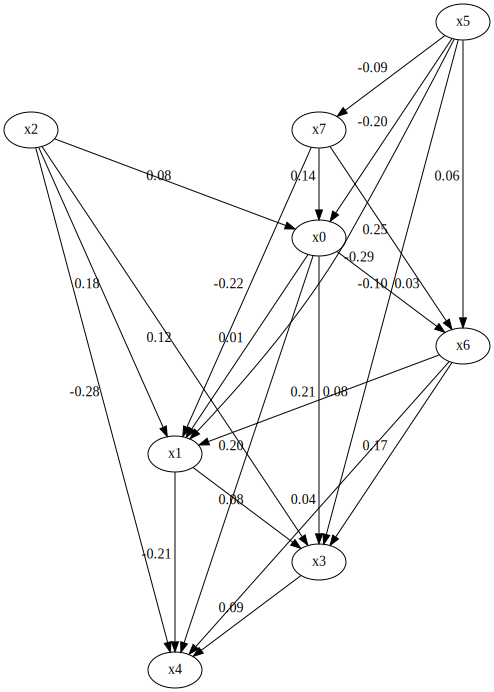

add edge 2 <- 6


### 巡回入れ込み

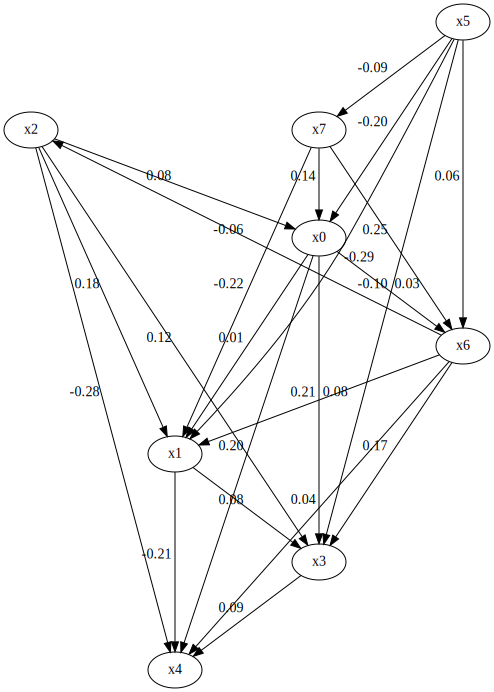

/tmp/ipykernel_21966/402821677.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(pd.DataFrame(adj, columns=columns, index=index).applymap(lambda x: f"{x:.2f}"))


lag=0                                                 lag=1                \
      x0     x1     x2    x3    x4     x5     x6     x7     x0     x1     x2   
x0  0.00   0.00   0.08  0.00  0.00  -0.20   0.00   0.14   0.00   0.00   0.12   
x1  0.01   0.00   0.18  0.00  0.00  -0.29   0.08  -0.22   0.13  -0.14   0.01   
x2  0.00   0.00   0.00  0.00  0.00   0.00  -0.06   0.00   0.05   0.00   0.21   
x3  0.21   0.08   0.12  0.00  0.00  -0.10   0.17   0.00   0.00   0.00   0.00   
x4  0.20  -0.21  -0.28  0.09  0.00   0.00   0.04   0.00   0.00  -0.22   0.00   
x5  0.00   0.00   0.00  0.00  0.00   0.00   0.00   0.00   0.00   0.00   0.28   
x6  0.03   0.00   0.00  0.00  0.00   0.06   0.00   0.25   0.00   0.00  -0.29   
x7  0.00   0.00   0.00  0.00  0.00  -0.09   0.00   0.00  -0.07  -0.08   0.27   

                                      lag=2                              \
       x3     x4    x5     x6     x7     x0     x1     x2     x3     x4   
x0   0.08   0.00  0.00   0.00  -0.18   0.00   0.00  -0.29   0.29   0.17   
x1   0.00   0.00  0.00  -0.11  -0.06  -0.29   0.00   0.00   0.00   0.06   
x2   0.20   0.14  0.09   0.00   0.00   0.00   0.00   0.00   0.00  -0.12   
x3  -0.17   0.00  0.00   0.22   0.00   0.00   0.00   0.00   0.10  -0.07   
x4   0.27  -0.03  0.00   0.00  -0.11  -0.13  -0.08  -0.01   0.07   0.00   
x5   0.00   0.13  0.06   0.00   0.22  -0.20  -0.04   0.00   0.00   0.00   
x6   0.08   0.00  0.00  -0.28   0.00   0.05   0.00  -0.27   0.02   0.00   
x7   0.01   0.23  0.00  -0.20   0.00   0.00   0.00  -0.21  -0.07   0.00   

                         
       x5     x6     x7  
x0   0.00   0.00   0.14  
x1  -0.08   0.00  -0.01  
x2   0.06   0.26   0.16  
x3   0.00   0.26   0.00  
x4  -0.18   0.02   0.00  
x5   0.00  -0.08   0.00  
x6   0.25   0.00   0.00  
x7   0.00   0.23   0.21

### 推定結果

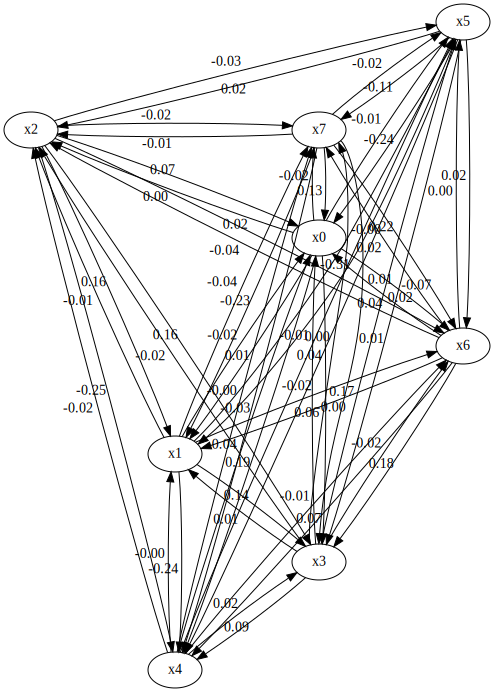

lag=0                                                   lag=1         \
       x0     x1     x2     x3     x4     x5     x6     x7     x0     x1   
x0   0.00  -0.02   0.07  -0.00  -0.04  -0.24   0.04   0.13  -0.02   0.01   
x1   0.01   0.00   0.16   0.01  -0.00  -0.31   0.06  -0.23   0.12  -0.19   
x2   0.00  -0.01   0.00  -0.02  -0.02   0.02  -0.04  -0.01   0.07   0.02   
x3   0.17   0.14   0.16   0.00   0.02  -0.07   0.18   0.01   0.02   0.02   
x4   0.19  -0.24  -0.25   0.09   0.00   0.04   0.07  -0.03  -0.02  -0.22   
x5  -0.01  -0.00  -0.03   0.02  -0.01   0.00   0.00  -0.02   0.02   0.01   
x6   0.01  -0.02   0.02  -0.02  -0.01   0.02   0.00   0.22   0.03  -0.00   
x7  -0.02  -0.04  -0.02   0.00  -0.00  -0.11   0.02   0.00  -0.07  -0.09   

                                             lag=2                       \
       x2     x3    x4     x5     x6     x7     x0     x1     x2     x3   
x0   0.17   0.06  0.02   0.05   0.06  -0.16  -0.01   0.00  -0.22   0.28   
x1  -0.02   0.03  0.04  -0.00  -0.18  -0.04  -0.26  -0.04  -0.03   0.04   
x2   0.19   0.23  0.13   0.15  -0.02   0.03  -0.02   0.02  -0.03  -0.01   
x3  -0.03  -0.19  0.02   0.02   0.24  -0.01   0.04   0.06  -0.03   0.10   
x4  -0.03   0.29  0.02   0.00   0.00  -0.13  -0.08  -0.03   0.05   0.05   
x5   0.25  -0.03  0.12   0.11  -0.03   0.21  -0.20  -0.05  -0.02   0.03   
x6  -0.25   0.07  0.02   0.02  -0.27  -0.04   0.04  -0.01  -0.27   0.03   
x7   0.30   0.04  0.26   0.06  -0.24  -0.02  -0.04   0.03  -0.19  -0.12   

                                
       x4     x5     x6     x7  
x0   0.17  -0.02   0.02   0.10  
x1   0.04  -0.07   0.03  -0.03  
x2  -0.16   0.00   0.27   0.13  
x3  -0.06   0.02   0.26  -0.03  
x4   0.01  -0.16   0.06  -0.00  
x5  -0.01   0.02  -0.05  -0.06  
x6   0.03   0.20  -0.01  -0.02  
x7  -0.01   0.01   0.21   0.22

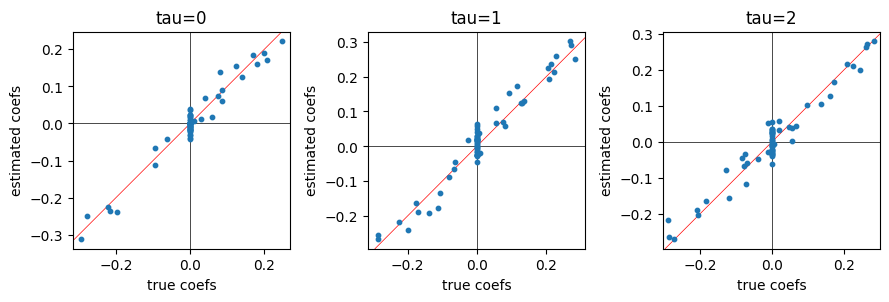

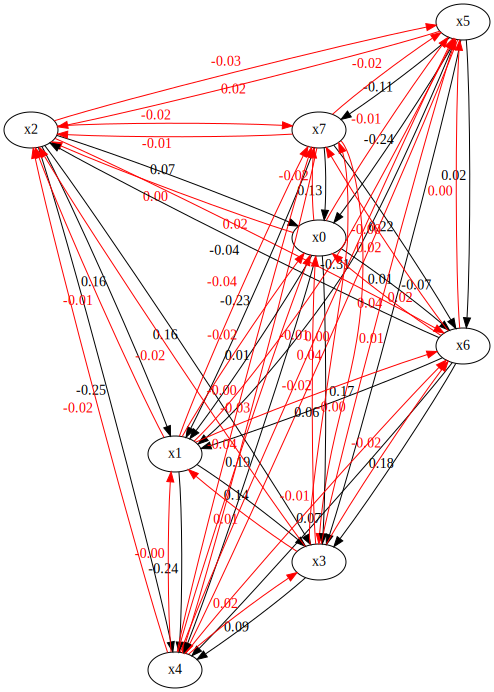

### 推定結果表示

RuntimeError: No active exception to reraise

In [3]:
np.random.seed(0)

n_features = 8
n_lags = 2
B, causal_order = _generate_var_graph(n_features=n_features, n_lags=n_lags, is_shuffle=True)
display(Markdown(f"### 巡回無し"))
#display(make_dot(B[0], lower_limit=0))
draw_graph(B[0])

B = _make_cycle_path(B, suppress=False)
display(Markdown(f"### 巡回入れ込み"))
#display(make_dot(B[0], lower_limit=0))
draw_graph(B[0])

pd.DataFrame(B[0]).to_csv("0.csv")
pd.DataFrame(B[1]).to_csv("1.csv")
pd.DataFrame(B[2]).to_csv("2.csv")

adj = np.hstack(B)
columns = pd.MultiIndex.from_tuples([(f"lag={i // n_features}", f"x{i % n_features}") for i in range(adj.shape[1])])
index = [f"x{i}" for i in range(adj.shape[0])]
display(pd.DataFrame(adj, columns=columns, index=index).applymap(lambda x: f"{x:.2f}"))

X = _make_var_data(B, T=1000)

# 推定
model = CyclicVARLiNGAM(lags=n_lags, k=3)
model.fit(X)

display(Markdown(f"### 推定結果"))
#display(make_dot(model.adjacency_matrices_[0], lower_limit=0))
draw_graph(model.adjacency_matrices_[0])

adj = np.hstack(model.adjacency_matrices_)
display(pd.DataFrame(adj, columns=columns, index=index).map(lambda x: f"{x:.2f}"))

# 複雑すぎ
_visualize(np.array([B]), np.array([model.adjacency_matrices_]))

# 結果の因果グラフの表示
draw_graph2(model.adjacency_matrices_[0], B[0])

# 差分
display(Markdown(f"### 推定結果表示"))

adj = np.hstack(model.adjacency_matrices_)
adj2 = np.hstack(B)
df = pd.DataFrame(adj, columns=columns, index=index).map(lambda x: f"{x:.2f}")
style = df.style

# 余計なエッジ
filter_ = ~np.isclose(adj, 0) & np.isclose(adj2, 0)
for x, y in np.argwhere(filter_):
    style = style.map(lambda x: "background-color:red;color:white", subset=(df.index[x], df.columns[y]))

# 足りないエッジ
filter_ = np.isclose(adj, 0) & ~np.isclose(adj2, 0)
for x, y in np.argwhere(filter_):
    style = style.map(lambda x: "background-color:blue;color:white", subset=(df.index[x], df.columns[y]))


raise
style

## ブートストラップ
causal_orderがないので因果効果の計算結果はすべてゼロのまま、VARBootstrapResultに格納している。結果の確認については[VARLINGAMのノートブック](https://github.com/haraoka-screen/lingam/blob/prototype_cyclic_var_lingam/examples/VARLiNGAM.ipynb)を参考にした。

In [ ]:
n_sampling = 100
bs_result = model.bootstrap(X, n_sampling)

### Causal Directions

In [ ]:
n_rows, n_cols = bs_result._adjacency_matrices[0].shape
n_features = n_rows
n_taus = n_cols // n_features

labels = []
for tau in range(n_taus):
    for feat_no in range(n_features):
        time = "t" if tau == 0 else f"t-{tau}"
        labels.append(f"x{feat_no}({time})")
        
cdc = bs_result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.01, split_by_causal_effect_sign=True)
print_causal_directions(cdc, n_sampling, labels=labels)

### Directed Acyclic Graphs

In [ ]:
dagc = bs_result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.2, split_by_causal_effect_sign=True)
print_dagc(dagc, n_sampling, labels=labels)

### Probability

In [ ]:
prob = bs_result.get_probabilities(min_causal_effect=0.1)
print('Probability of B0:\n', prob[0])
print('Probability of B1:\n', prob[1])
print('Probability of B2:\n', prob[2])

巡回により因果順序を持たないため、因果効果が計算できない。そのためTotal Causal Effects以降は実行しない。

## 巡回無しデータ&VARLiNGAM

In [ ]:
# VARLiNGAMのラグ数は最大以下の最適なものを選択するので、shapeが変わることがある。
#test(lambda **kwargs: VARLiNGAM(**kwargs))

## 巡回有りデータ&VARLiNGAM

In [ ]:
# VARLiNGAMのラグ数は最大以下の最適なものを選択するので、shapeが変わることがある。
#test(lambda **kwargs: VARLiNGAM(**kwargs), is_cyclic=True)

## 巡回無しデータ&CyclicVARLiNGAM

In [ ]:
test(lambda **kwargs: CyclicVARLiNGAM(**kwargs, k=3), is_cyclic=False)

## 巡回有りデータ&CyclicVARLiNGAM

In [ ]:
test(lambda **kwargs: CyclicVARLiNGAM(**kwargs, k=3), is_cyclic=True)